## Why Active Learning?

* Experimental result of semi-supervised learning suggests that higher portion of annotated data ensures better performance.
* But, annotation is expensive and time-consuming. Thus, limiting the budget.
* Active learning is a solution to this problem as it selects data points that are most informative and asks for annotation of these data points only.

## What is Active Learning?

* Model actively selects data points that the model is uncertain about. Using the selected data points, the model is retrained.
* Eg: In a classification task, the model selects data points that are close to the decision boundary. Later, the model is retrained using the selected data points.
* Lets' demonstrate this using CIFAR-10 example.

In [25]:
import torch
import random
import numpy as np
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data.sampler import SubsetRandomSampler

# Torchvison
import torchvision.transforms as T
from torchvision.datasets import CIFAR10

In [26]:
import os

os.environ["TF_XLA_FLAGS"] = "--tf_xla_enable_xla_devices"  ## setting the environment
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"  ## using GPU core 1

### Model Architecture

In [27]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

In [28]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out1 = self.layer1(out)
        out2 = self.layer2(out1)
        out3 = self.layer3(out2)
        out4 = self.layer4(out3)
        out = F.avg_pool2d(out4, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out, [out1, out2, out3, out4]

In [29]:
def ResNet18(num_classes = 10):
    return ResNet(BasicBlock, [2,2,2,2], num_classes)

### Data Transformation (CIFAR-10)

In [30]:
train_transform = T.Compose([
    T.RandomHorizontalFlip(),
    T.RandomCrop(size=32, padding=4),
    T.ToTensor(),
    T.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010]) 
])

test_transform = T.Compose([
    T.ToTensor(),
    T.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010]) 
])

In [31]:
cifar10_train = CIFAR10('../cifar10', train=True, download=True, transform=train_transform)
cifar10_unlabeled   = CIFAR10('../cifar10', train=True, download=True, transform=test_transform)
cifar10_test  = CIFAR10('../cifar10', train=False, download=True, transform=test_transform)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [32]:
class SubsetSequentialSampler(torch.utils.data.Sampler):
    def __init__(self, indices):
        self.indices = indices

    def __iter__(self):
        return (self.indices[i] for i in range(len(self.indices)))
    
    def __len__(self):
        return len(self.indices)

#### Visualising the dataset

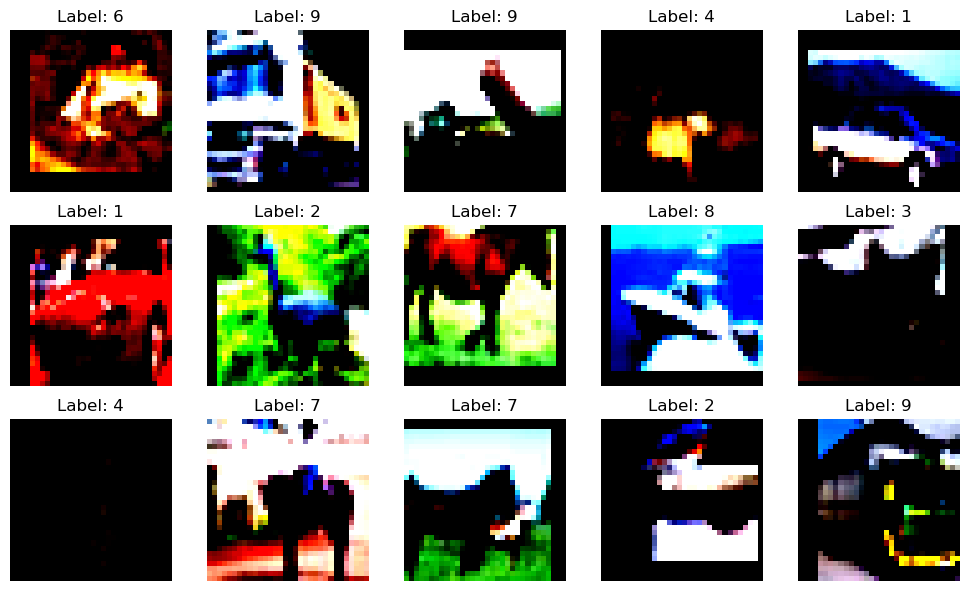

In [33]:
# plot some sample images from the dataset
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(10, 6))
for i, ax in enumerate(axes.flat):
    img, label = cifar10_train[i]
    img = np.clip(img.permute(1, 2, 0), 0, 1) # clip the input image for the valid range for imshow
    ax.imshow(img)
    ax.set_title(f"Label: {label}")
    ax.axis('off')
plt.tight_layout()
plt.show()

# cifar_10_labels = {0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer',
# 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}

#### Training & Testing function

In [34]:
def train(model, criterion, optimizer, dataloaders, num_epochs, scheduler):
    model.train()
    train_accuracy = []
    for epoch in range(num_epochs):
        scheduler.step()

        train_total = 0
        train_correct = 0

        for data in tqdm(dataloaders['train'], leave=False, total=len(dataloaders['train'])):
            inputs = data[0].cuda()
            labels = data[1].cuda()
            optimizer.zero_grad()

            scores, features = model(inputs)
            target_loss = criterion(scores, labels)
            _, preds = torch.max(scores.data, 1)
            train_total += labels.size(0)
            train_correct += (preds == labels).sum().item()

            loss = torch.sum(target_loss) / target_loss.size(0)
            loss.backward()
            optimizer.step()

        train_acc = 100* train_correct / train_total
        train_accuracy.append(train_acc)
        
        # Evaluating test loss
        total = 0
        correct = 0
        model.eval()
        for data in dataloaders['test']:
            inputs = data[0].cuda()
            labels = data[1].cuda()

            scores, features = model(inputs)
            _, preds = torch.max(scores.data, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()

        test_acc = 100* correct / total
        
    return train_accuracy, test_acc

#### Using Entropy as the acquisition function for active learning

In [35]:
def entropy(model, unlabeled_loader):
    model.eval()
    entropies = []
    with torch.no_grad():
        for data in unlabeled_loader:
            inputs = data[0].cuda()
            scores, _ = model(inputs)
            entropy = -torch.sum(F.softmax(scores, dim=1) * F.log_softmax(scores, dim=1), dim=1)
            entropies.append(entropy.cpu().numpy())
    return np.concatenate(entropies)

In [36]:
## CONFIG

NUM_TRAIN = 50000
BATCH = 128
ADDENDUM = 1000
SUBSET = 10000
MOMENTUM = 0.9
WDECAY = 5e-4
LR = 0.01
CYCLES = 5
MILESTONES = [160]
EPOCH = 40

#### Active Learning Loop

In [37]:
indices = list(range(NUM_TRAIN))
random.shuffle(indices)
labeled_set = indices[:ADDENDUM]
unlabeled_set = indices[ADDENDUM:]

test_accuracy_list = []
train_accuracy_list = []

train_loader = DataLoader(cifar10_train, batch_size=BATCH, sampler=SubsetRandomSampler(labeled_set), pin_memory=True)
test_loader  = DataLoader(cifar10_test, batch_size=BATCH)
dataloaders  = {'train': train_loader, 'test': test_loader}

# Model
resnet18    = ResNet18(num_classes=10).cuda()
torch.backends.cudnn.benchmark = False

# Active learning cycles
for cycle in range(CYCLES):
    criterion = nn.CrossEntropyLoss(reduction='none')
    optimizer = optim.SGD(resnet18.parameters(), lr=LR, momentum=MOMENTUM, weight_decay=WDECAY)
    scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=MILESTONES)

    # Training and test
    train_acc, test_acc = train(resnet18, criterion, optimizer, dataloaders, EPOCH, scheduler)
    test_accuracy_list.append(test_acc)
    train_accuracy_list.append(train_acc)
    print('Cycle {}/{} || Label set size {}: Test Accuracy {} '.format(cycle+1, CYCLES, len(labeled_set), test_acc))

    random.shuffle(unlabeled_set)
    subset = unlabeled_set[:SUBSET]

    # Create unlabeled dataloader for the unlabeled subset
    unlabeled_loader = DataLoader(cifar10_unlabeled, batch_size=BATCH, sampler=SubsetSequentialSampler(subset), pin_memory=True)

    # Measure uncertainty of each data points in the subset
    uncertainty = entropy(resnet18, unlabeled_loader)

    # Index in ascending order
    arg = np.argsort(uncertainty)
    
    # Update the labeled dataset and the unlabeled dataset, respectively
    labeled_set += list(torch.tensor(subset)[arg][-ADDENDUM:].numpy())
    unlabeled_set = list(torch.tensor(subset)[arg][:-ADDENDUM].numpy()) + unlabeled_set[SUBSET:]

    # Create a new dataloader for the updated labeled dataset
    dataloaders['train'] = DataLoader(cifar10_train, batch_size=BATCH, sampler=SubsetRandomSampler(labeled_set), 
                                        pin_memory=True)

/home/project_3/anaconda3/envs/gan/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Cycle 1/5 || Label set size 1000: Test Accuracy 39.01 


Cycle 2/5 || Label set size 2000: Test Accuracy 51.99 


Cycle 3/5 || Label set size 3000: Test Accuracy 57.39 


Cycle 4/5 || Label set size 4000: Test Accuracy 62.73 


Cycle 5/5 || Label set size 5000: Test Accuracy 65.35 


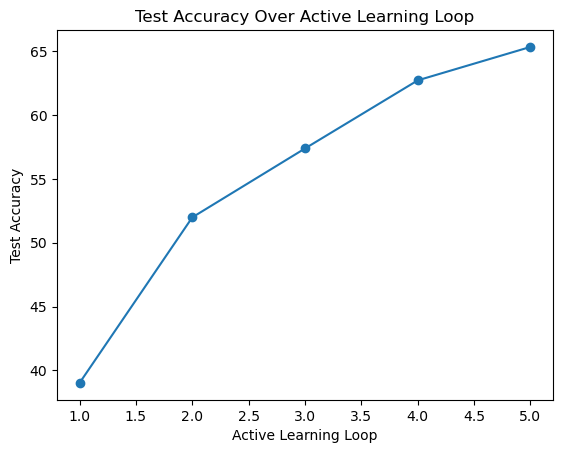

In [38]:
active_learning_loop = [1, 2, 3, 4, 5]  # Active learning loop numbers 

plt.plot(active_learning_loop, test_accuracy_list, marker='o', linestyle='-')

plt.xlabel('Active Learning Loop')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy Over Active Learning Loop')
plt.show()


## Learning to Loss Active Learning

* In this active learning a loss prediction module is attached to the target network to predict the loss.
* This module is then used to suggest the data that the target module is likely to produce a wrong prediction on.

#### Loss for the loss prediction network

\begin{array}{r}
L_{\text {loss }}\left(\hat{l p}, l^p\right)= 
\max \left(0,-\mathbb{1}\left(l_i, l_j\right) \cdot\left(\hat{l_i}-\hat{l_j}\right)+\xi\right) 
\text { s.t. } \mathbb{1}\left(l_i, l_j\right)= \begin{cases}+1, & \text { if } l_i>l_j \\
-1, & \text { otherwise }\end{cases}
\end{array}

We learn the loss prediction module by considering the difference between a pair of loss predictions, which completely make the loss prediction module discard the overall scale changes

In [39]:
def LossPredLoss(input, target, margin=1.0):
    assert len(input) % 2 == 0, 'the batch size is not even.'
    assert input.shape == input.flip(0).shape
    
    input = (input - input.flip(0))[:len(input)//2] # [l_1 - l_2B, l_2 - l_2B-1, ... , l_B - l_B+1], where batch_size = 2B
    target = (target - target.flip(0))[:len(target)//2]
    target = target.detach()

    one = 2 * torch.sign(torch.clamp(target, min=0)) - 1 # 1 operation which is defined by the authors
    loss = torch.sum(torch.clamp(margin - one * input, min=0))
    loss = loss / input.size(0) # Note that the size of input is already halved

    return loss

#### LossNet

* LossNet takes in as input the output from the intermediate layer of the target network to predict the loss.


    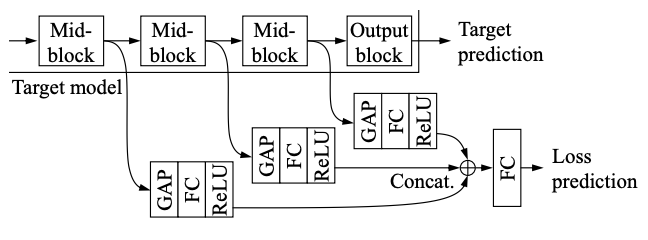

In [40]:
class LossNet(nn.Module):
    def __init__(self, feature_sizes=[32, 16, 8, 4], num_channels=[64, 128, 256, 512], interm_dim=128):
        super(LossNet, self).__init__()
        
        self.GAP1 = nn.AvgPool2d(feature_sizes[0])
        self.GAP2 = nn.AvgPool2d(feature_sizes[1])
        self.GAP3 = nn.AvgPool2d(feature_sizes[2])
        self.GAP4 = nn.AvgPool2d(feature_sizes[3])

        self.FC1 = nn.Linear(num_channels[0], interm_dim)
        self.FC2 = nn.Linear(num_channels[1], interm_dim)
        self.FC3 = nn.Linear(num_channels[2], interm_dim)
        self.FC4 = nn.Linear(num_channels[3], interm_dim)

        self.linear = nn.Linear(4 * interm_dim, 1)
    
    def forward(self, features):
        out1 = self.GAP1(features[0])
        out1 = out1.view(out1.size(0), -1)
        out1 = F.relu(self.FC1(out1))

        out2 = self.GAP2(features[1])
        out2 = out2.view(out2.size(0), -1)
        out2 = F.relu(self.FC2(out2))

        out3 = self.GAP3(features[2])
        out3 = out3.view(out3.size(0), -1)
        out3 = F.relu(self.FC3(out3))

        out4 = self.GAP4(features[3])
        out4 = out4.view(out4.size(0), -1)
        out4 = F.relu(self.FC4(out4))

        out = self.linear(torch.cat((out1, out2, out3, out4), 1))
        return out

In [41]:
# Function for evaluating the test accuracy
def test(models, dataloaders, mode='val'):
    assert mode == 'val' or mode == 'test'
    models['backbone'].eval()
    models['module'].eval()

    total = 0
    correct = 0
    with torch.no_grad():
        for (inputs, labels) in dataloaders[mode]:
            inputs = inputs.cuda()
            labels = labels.cuda()

            scores, _ = models['backbone'](inputs)
            _, preds = torch.max(scores.data, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()
    
    return 100 * correct / total

In [42]:
# Training function for both the target model and the loss prediction module
def train(models, criterion, optimizers, schedulers, dataloaders, num_epochs, epoch_loss):
    for epoch in range(num_epochs):
        schedulers['backbone'].step()
        schedulers['module'].step()

        models['backbone'].train()
        models['module'].train()

        for data in tqdm(dataloaders['train'], leave=False, total=len(dataloaders['train'])):
            inputs = data[0].cuda()
            labels = data[1].cuda()

            optimizers['backbone'].zero_grad()
            optimizers['module'].zero_grad()

            scores, features = models['backbone'](inputs)
            target_loss = criterion(scores, labels)

            # After 120 epochs, stop the gradient from the loss prediction module propagated to the target model.
            if epoch > epoch_loss:
                features[0] = features[0].detach()
                features[1] = features[1].detach()
                features[2] = features[2].detach()
                features[3] = features[3].detach()
            pred_loss = models['module'](features)
            pred_loss = pred_loss.view(pred_loss.size(0))

            # Combined loss function
            m_backbone_loss = torch.sum(target_loss) / target_loss.size(0)
            m_module_loss   = LossPredLoss(pred_loss, target_loss, margin=MARGIN)
            loss            = m_backbone_loss + WEIGHT * m_module_loss

            loss.backward()
            optimizers['backbone'].step()
            optimizers['module'].step()

In [43]:
# Selecting the acquisition points based on the predictions of the loss prediction module
def get_uncertainty(models, unlabeled_loader):
    models['backbone'].eval()
    models['module'].eval()
    uncertainty = torch.tensor([]).cuda()

    with torch.no_grad():
        for (inputs, labels) in unlabeled_loader:
            inputs = inputs.cuda()
            scores, features = models['backbone'](inputs)
            pred_loss = models['module'](features) 
            pred_loss = pred_loss.view(pred_loss.size(0))

            uncertainty = torch.cat((uncertainty, pred_loss), 0)
    return uncertainty.cpu()

In [44]:
EPOCHL = 120       # After EPOCHL, stop the gradient from the loss prediction module propagated to the target model.
MARGIN = 1.0 
WEIGHT = 1.0

In [45]:
indices = list(range(NUM_TRAIN))
random.shuffle(indices)
labeled_set = indices[:ADDENDUM]
unlabeled_set = indices[ADDENDUM:]

test_accuracy_lal = []

train_loader = DataLoader(cifar10_train, batch_size=BATCH, sampler=SubsetRandomSampler(labeled_set), pin_memory=True)
test_loader  = DataLoader(cifar10_test, batch_size=BATCH)
dataloaders  = {'train': train_loader, 'test': test_loader}

# Model
resnet18    = ResNet18(num_classes=10).cuda()
loss_module = LossNet().cuda()
models      = {'backbone': resnet18, 'module': loss_module}
torch.backends.cudnn.benchmark = False

# Active learning cycles
for cycle in range(CYCLES):
    # Loss, criterion and scheduler (re)initialization
    criterion      = nn.CrossEntropyLoss(reduction='none')
    optim_backbone = optim.SGD(models['backbone'].parameters(), lr=LR, 
                            momentum=MOMENTUM, weight_decay=WDECAY)
    optim_module   = optim.SGD(models['module'].parameters(), lr=LR, 
                            momentum=MOMENTUM, weight_decay=WDECAY)
    sched_backbone = lr_scheduler.MultiStepLR(optim_backbone, milestones=MILESTONES)
    sched_module   = lr_scheduler.MultiStepLR(optim_module, milestones=MILESTONES)

    optimizers = {'backbone': optim_backbone, 'module': optim_module}
    schedulers = {'backbone': sched_backbone, 'module': sched_module}

    # Training and test
    train(models, criterion, optimizers, schedulers, dataloaders, EPOCH, EPOCHL)
    acc = test(models, dataloaders, mode='test')
    test_accuracy_lal.append(acc)
    print('Cycle {}/{} || Label set size {}: Test acc {}'.format(cycle+1, CYCLES, len(labeled_set), acc))

    # Randomly sample 10000 unlabeled data points
    random.shuffle(unlabeled_set)
    subset = unlabeled_set[:SUBSET]

    # Create unlabeled dataloader for the unlabeled subset
    unlabeled_loader = DataLoader(cifar10_unlabeled, batch_size=BATCH, sampler=SubsetSequentialSampler(subset), pin_memory=True)

    # Measure uncertainty of each data points in the subset
    uncertainty = get_uncertainty(models, unlabeled_loader)

    # Index in ascending order
    arg = np.argsort(uncertainty)
    
    # Update the labeled dataset and the unlabeled dataset, respectively
    labeled_set += list(torch.tensor(subset)[arg][-ADDENDUM:].numpy())
    unlabeled_set = list(torch.tensor(subset)[arg][:-ADDENDUM].numpy()) + unlabeled_set[SUBSET:]

    # Create a new dataloader for the updated labeled dataset
    dataloaders['train'] = DataLoader(cifar10_train, batch_size=BATCH, sampler=SubsetRandomSampler(labeled_set), pin_memory=True)

  0%|          | 0/8 [00:00<?, ?it/s]

Cycle 1/5 || Label set size 1000: Test acc 43.6


Cycle 2/5 || Label set size 2000: Test acc 50.23


Cycle 3/5 || Label set size 3000: Test acc 57.39


Cycle 4/5 || Label set size 4000: Test acc 63.17


Cycle 5/5 || Label set size 5000: Test acc 69.3


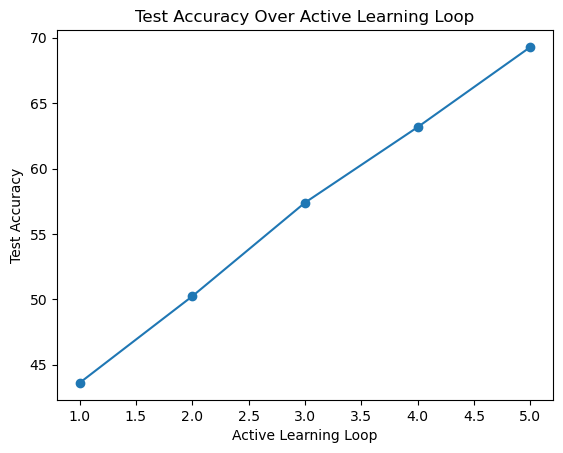

In [46]:
active_learning_loop = [1, 2, 3, 4, 5]  # Active learning loop numbers 
plt.plot(active_learning_loop, test_accuracy_lal, marker='o', linestyle='-')

plt.xlabel('Active Learning Loop')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy Over Active Learning Loop')
plt.show()


## References:
1. https://arxiv.org/pdf/1905.03677.pdf
2. https://github.com/Mephisto405/Learning-Loss-for-Active-Learning